# Устанавливаем и импортируем необходимые библиотеки

In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 66 kB 4.1 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627448 sha256=5b2390bf88ee5e89dc5fdfc19163a59f97c1e804fb4f133d64c4a62848dcf414
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=a33c375775b89b31633f548bfd5d27db34cf40d12dfaa7399b39d637934dabc6
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import pycuda.autoinit
from pycuda.driver import In, Out, Context
from pycuda.compiler import SourceModule
from PIL import Image
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")

In [10]:
df = pd.DataFrame(columns=["Filename", "CPU Time", "GPU Time", "Speed Up"])
CPU_TEST, GPU_TEST = 5, 5
BLOCK_SIZE = 32
BLOCK = (BLOCK_SIZE, BLOCK_SIZE, 1)
FILTER_SIZE = 3
ARRAY_SIZE = FILTER_SIZE ** 2
OFFSET = FILTER_SIZE // 2
FILE_NAMES = ["256.bmp", "512.bmp", "1024.bmp"]

# Реализация функции на GPU 

---

Здесь каждый элемент выходного изображения на GPU вычислялся отдельной нить(потоком). Чтобы ускорить вычисленя на GPU, внутри каждого блока изображения была выполнена реализация копирования элементов из глобальной памяти в разделяемую, данная манипуляция позволила нам уменьшить число обращений к глобальной памяти.



In [3]:
kernel = SourceModule("""
__global__ void median_filter(unsigned char* pixels, unsigned char* filtered, int* size){
  const int blockSize = %(BLOCK_SIZE)s;
  const int arraySize = %(ARRAY_SIZE)s;
  const int filterSize = %(FILTER_SIZE)s;
  const int offset = %(OFFSET)s;
  int width = size[0];
  int bx = blockIdx.x, by = blockIdx.y, tx = threadIdx.x, ty = threadIdx.y;
  int j = bx * blockDim.x + tx; 
  int i = by * blockDim.y + ty;
	int x, y, index;
  __shared__ int local[blockSize][blockSize];
  int arr[arraySize];
  local[ty][tx] = pixels[i * width + j];
  __syncthreads ();
  for (int k = 0; k < filterSize; k++){
    x = max(0, min(ty + k - offset, blockSize - 1));
    for (int l = 0; l < filterSize; l++){
      index = k * filterSize + l;
      y = max(0, min(tx + l - offset, blockSize - 1));
      arr[index] = local[x][y];
      }
    }
    __syncthreads ();
    for (int k = 0; k < arraySize; k++){
      for (int l = k + 1; l < arraySize; l++){
        if (arr[k] > arr[l]){
          unsigned char temp = arr[k];
          arr[k] = arr[l];
          arr[l] = temp;
          }
        }
      }
      filtered[i * width + j] = arr[int(arraySize / 2)];
    }
    """ % {
        'BLOCK_SIZE' : BLOCK_SIZE,
        'ARRAY_SIZE' : ARRAY_SIZE,
        'OFFSET' : OFFSET,
        'FILTER_SIZE' : FILTER_SIZE
    }
)

median_filter = kernel.get_function("median_filter")

def gpu_filter(pixels, width, height):
    size = np.array([width, height])
    filtered = np.zeros_like(pixels)
    grid_dim = (width // BLOCK_SIZE, height // BLOCK_SIZE)
    median_filter(In(pixels), Out(filtered), In(size), block=BLOCK, grid=grid_dim)
    Context.synchronize()
    return filtered

# Реализация функции на CPU

In [4]:
def cpu_filter(pixels, width, height):
    filtered = np.zeros_like(pixels)
    median = ARRAY_SIZE // 2
    for i in range(height):
        for j in range(width):
            arr = np.zeros(ARRAY_SIZE)
            for k in range(FILTER_SIZE):
                x = max(0, min(i + k - OFFSET, height - 1))
                index = k * FILTER_SIZE
                for l in range(FILTER_SIZE):
                    y = max(0, min(j + l - OFFSET, width - 1))
                    arr[index + l] = pixels[x, y]
            arr.sort()
            filtered[i, j] = arr[median]
    return filtered

# Функция для открытия изображения

In [5]:
def open_image(filename: str):
    image = Image.open(filename)
    pixel = image.load()
    width, height = image.size[0], image.size[1]
    pixels = np.zeros((width, height), dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            pixels[i, j] = pixel[j, i]
    return pixels, width, height

# Каждое выходное изображение мы будем сохранять в формате BMP

In [6]:
def save_image(filtered, filename):
    new_image = Image.fromarray(filtered.astype('uint8'), mode='L')
    new_image.save(filename, format="BMP")

# Запуск функций на CPU/GPU

In [7]:
def start_test_cpu(pixels, width, height, save):
    start_cpu_timer = time.time()
    filtered = cpu_filter(pixels, width, height)
    end_cpu_timer = time.time() - start_cpu_timer
    if save: save_image(filtered, "/content/cpu_result/" + filename)
    return end_cpu_timer


def start_test_gpu(pixels, width, height, save):
    start_gpu_timer = time.time()
    filtered = gpu_filter(pixels, width, height)
    end_gpu_timer = time.time() - start_gpu_timer
    if save: save_image(filtered, "/content/gpu_result/" + filename)
    return end_gpu_timer

# Запуск всех написанных выше функций, засекаем время выполнения, тесты будут проходить на фотографиях разной размерности (256x256, 512x512, 1024x1024))

In [12]:
for filename in FILE_NAMES:
    pixels, width, height = open_image("/content/sample_data/" + filename)
    start_test_cpu(pixels, width, height, True)
    start_test_gpu(pixels, width, height, True)
    cpu_time, gpu_time = 0, 0
    
    for _ in tqdm(range(CPU_TEST)):
        cpu_time += start_test_cpu(pixels, width, height, False)

    for _ in tqdm(range(GPU_TEST)):
        gpu_time += start_test_gpu(pixels, width, height, False)

    df = df.append({
        "Filename": filename,
        "CPU Time": cpu_time,
        "GPU Time": gpu_time,
        "Speed Up": cpu_time/gpu_time
    }, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Смотрим результат

In [13]:
df.head()

,Filename,CPU Time,GPU Time,Speed Up
0,256.bmp,5.830293,0.005179,1125.720296
1,512.bmp,24.452166,0.012810,1908.835433
2,1024.bmp,98.563212,0.019331,5098.781127


In [14]:
df.to_markdown()

'|    | Filename   |   CPU Time |   GPU Time |   Speed Up |\n|---:|:-----------|-----------:|-----------:|-----------:|\n|  0 | 256.bmp    |    5.83029 | 0.00517917 |    1125.72 |\n|  1 | 512.bmp    |   24.4522  | 0.01281    |    1908.84 |\n|  2 | 1024.bmp   |   98.5632  | 0.0193307  |    5098.78 |'

# Визуализация результатов

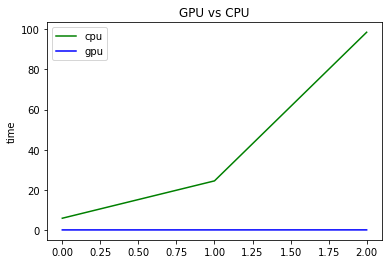

In [18]:
plt.plot(df["CPU Time"], color="green", label="cpu")
plt.plot(df["GPU Time"], color="blue", label="gpu")
plt.title("GPU vs CPU")
plt.ylabel("time")
plt.legend()
plt.show()

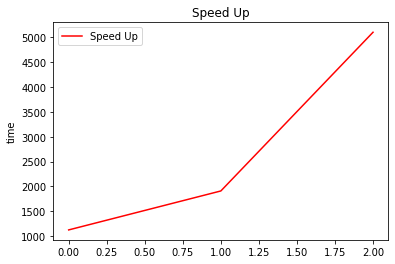

In [19]:
plt.plot(df["Speed Up"], color="red", label="Speed Up")
plt.title("Speed Up")
plt.ylabel("time")
plt.legend()
plt.show()